In [32]:
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
import brighteyes_ism.simulation.PSF_sim as sim
import brighteyes_ism.analysis.Graph_lib as gra
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.analysis.Deconv_lib as dec
import brighteyes_ism.analysis.FRC_lib as frc
import brighteyes_ism.simulation.Tubulin_sim as simTub
import lib as flim
import napari as nap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve
from skimage.filters import gaussian
path = '/home/lcuneo/Documents/PostDoc/VS_Code/Bufalino/Code/'
os.chdir(path)
from s2ISM.src.s2ism import s2ism as s2
from s2ISM.src.s2ism import unmixing as unmix
from s2ISM.src.s2ism import psf_estimator as psf_est


In [2]:
# %% Set Plot parameters for figures
plt.close('all')

plt.rcParams['ps.fonttype'] = 42
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [3]:
wd_path = os.getcwd()
files_path = os.path.join(wd_path, 'files')
if not os.path.exists(files_path):
    os.makedirs(files_path)

In [4]:
# %% psf
b = np.finfo(float).eps

exPar = sim.simSettings()
exPar.na = 1.4   # numerical aperture
exPar.wl = 640   # wavelength [nm]
exPar.gamma = 45  # parameter describing the light polarization
exPar.beta = 90  # parameter describing the light polarization
exPar.n = 1.5
exPar.mask_sampl = 151

emPar = exPar.copy()
emPar.wl = 660

grid = sim.GridParameters()
grid.Nz = 1
grid.pxsizex = 40
grid.pxsizez = 720
grid.pxpitch = 75e3
grid.pxdim = 50e3
grid.N = 5
grid.Nx = 71

file_psf = os.path.join(files_path, 'PSFs.npy') 

if os.path.exists(file_psf):
    psf = np.load(file_psf)
else:
    psf = sim.SPAD_PSF_3D(grid, exPar, emPar,stack ='positive')[0]
    np.save(file_psf, psf)


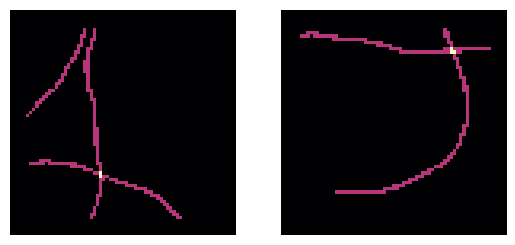

In [5]:
# %% phantom object
file_gt = os.path.join(files_path, 'simulated_tubulin_unmixing.npz')   

ntau = 2

if os.path.exists(file_gt):
    phTub = np.load(file_gt)['phantom']
else:
    tubulin = simTub.tubSettings()
    tubulin.xy_pixel_size = 60
    tubulin.xy_dimension = grid.Nx-10
    tubulin.xz_dimension = 1
    tubulin.z_pixel = 1
    tubulin.n_filament = 1
    tubulin.radius_filament = grid.pxsizex
    tubulin.intensity_filament = [1, 1]

    phTub = np.empty((ntau, tubulin.xy_dimension, tubulin.xy_dimension))

    for n in range(ntau):
        phTub[n] = np.squeeze(simTub.functionPhTub(tubulin))
        phTub[n] += np.squeeze(simTub.functionPhTub(tubulin)).T
        phTub[n] += np.fliplr(np.squeeze(simTub.functionPhTub(tubulin)))
        # phTub[n] += np.flipud(np.squeeze( simTub.functionPhTub(tubulin) ))
        # if n==0:
        # phTub[n] += np.fliplr(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.flipud(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.fliplr(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.flipud(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.fliplr(np.squeeze( simTub.functionPhTub(tubulin) ))
        # phTub[n] += np.flipud(np.squeeze( simTub.functionPhTub(tubulin) ))

    np.savez(file_gt, phantom=phTub, tub_settings=tubulin)
    
#%%
    
phTub = np.pad(phTub,((0,0),(5,5),(5,5)))


fig, ax = plt.subplots(1, ntau)
for tau in range(ntau):
    ax[tau].imshow(phTub[tau], cmap='magma')
    ax[tau].axis('off')
    

# %%
flux = 1e3
ground_truth = phTub * flux

del phTub

In [6]:
# %% IRF
dt = 0.4  # ns
nbin = 81
Nch = 25

irf = unmix.generate_delta_IRFs(time_shifts='mid', Nbin=nbin)
ST_response = psf_est.combine_psf_irf(psf, irf)

Text(0.5, 1.0, 'Ideal decay functions')

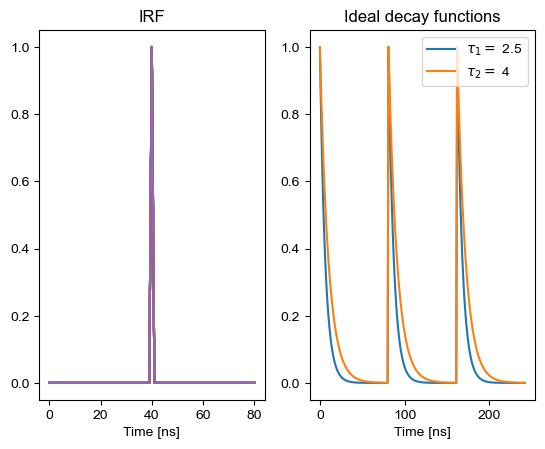

In [7]:
# %% Temporal decay
def exp_decay(tau, t):
    decay = np.exp(-t/tau)
    decay[t < 0] = 0
    return decay

#%%
time = np.arange(3*nbin)*dt
tau_1 = 2.5  # ns
tau_2 = 4  # ns

period = nbin*dt
decay_1 = 0
decay_2 = 0

for tc in [-1, 0, 1]:
    decay_1 += exp_decay(tau_1, time-nbin*dt-tc*period)
    decay_2 += exp_decay(tau_2, time-nbin*dt-tc*period)

decay_w = np.stack((decay_1, decay_2))

del decay_1, decay_2

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(irf)
ax1.set_title('IRF')
ax1.set_xlabel('Time [ns]')
ax2.plot(decay_w[0], label=r'$\tau_1 = $ {}'.format(tau_1))
ax2.plot(decay_w[1], label=r'$\tau_2 = $ {}'.format(tau_2))
ax2.set_xlabel('Time [ns]')
ax2.legend()
ax2.set_title('Ideal decay functions')

In [8]:
#%% dataset construction
irf_dec = np.empty((ntau,nbin*3))

for i in range(ntau):
    irf_dec[i] = convolve(decay_w[i], irf[:,0], mode='same')
     

# %%
psf = np.squeeze(psf)
psf_fin = np.repeat(psf, 3*nbin).reshape((grid.Nx, grid.Nx, 25, 3*nbin))
psf_fin = np.einsum('ijkl , ml -> ijkml', psf_fin, irf_dec)

#del irf_fin
#irf = irf[nbin:-nbin]

#%%
for i in range(ntau):
    psf_fin[:,:,:,i]/=psf_fin[:,:,:,i].sum()
    
Nx = grid.Nx
Nch = 5
dataset = np.empty([ntau, Nx, Nx, Nch**2, 3*nbin])

for i in range(Nch**2):
    for j in range(ntau):
        for l in range(nbin*3):
            dataset[j, :, :, i, l] = convolve(ground_truth[j,...], psf_fin[:,:,i,j,l], mode='same')

dataset[dataset < 0] = 0
d = dataset.sum(axis=0)

datafin = np.swapaxes(d,-2,-1)
del d

#%%
dataset_noise = np.random.poisson(datafin)
dataset_noise = np.swapaxes(dataset_noise,-1,-2)
del datafin

# %%
irf_dec = irf_dec[..., nbin:-nbin]
psf_fin = psf_fin[..., nbin:-nbin]
dataset_noise = dataset_noise[..., nbin:-nbin]
decay_1 = decay_w[0,..., nbin:-nbin]
decay_2 = decay_w[1,..., nbin:-nbin]

del decay_w, dataset

# %%
dataset_noise = np.swapaxes(dataset_noise,-1,-2)

#%%
psf_fin = np.swapaxes(psf_fin,-3,-1)  #(x y t tau nch)
psf_fin = np.swapaxes(psf_fin,0,-2)  #(tau y t x nch)
psf_fin = np.swapaxes(psf_fin,-3,-2)  #(tau y x t nch)
psf_fin = np.swapaxes(psf_fin,1,2)  #(tau x y t nch)

Text(0.5, 1.0, 'Final decay functions')

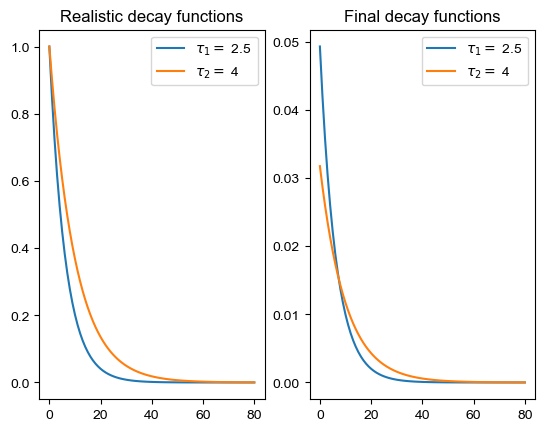

In [9]:
#%% Plots decays

#%%
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(irf_dec[0], label=r'$\tau_1 = $ {}'.format(tau_1))
ax1.plot(irf_dec[1], label=r'$\tau_2 = $ {}'.format(tau_2))
ax1.legend()
ax1.set_title('Realistic decay functions')

#%%
ax2.plot(np.sum(psf_fin[0],axis=(0,1,-1)), label=r'$\tau_1 = $ {}'.format(tau_1))
ax2.plot(np.sum(psf_fin[1],axis=(0,1,-1)), label=r'$\tau_2 = $ {}'.format(tau_2))
ax2.legend()
ax2.set_title('Final decay functions')

In [ ]:
fig, ax = plt.subplots(5, 5)
for i in range(Nch):
    for j in range(Nch):
        ax[i,j].plot(np.sum(psf_fin[0, ..., i*Nch+j],axis=(0,1)), label=r'$\tau_1 = $ {}'.format(tau_1))
        ax[i,j].plot(np.sum(psf_fin[1, ..., i*Nch+j],axis=(0,1)), label=r'$\tau_2 = $ {}'.format(tau_2))
        ax[i,j].set_ylim([0,3e-3])
        #ax[i*Nch,j].legend()
        #ax[i,j].axis('off')
fig.tight_layout()

In [10]:
## s2ISM spatial reconstruction MAIN code

import gc
from collections.abc import Iterable

from tqdm import tqdm

import torch
import torch.nn.functional as torchpad
from torch.fft import fftn, ifftn, ifftshift


def optimized_conv(signal, kernel_fft):
    """
    It calculates the 2D circular convolution of a real signal with a kernel using the FFT method using pytorch.

    Parameters
    ----------
    signal : torch.Tensor
        Tensor with dimensions (Nz, Nx, Ny, T) OR (Nx, Ny, T, Ch) to be convolved.
    kernel_fft : torch.Tensor
        Kernel with dimension (Nz, Nx, Ny, T, Ch) in the frequency domain of the convolution.

    Returns
    -------
        conv : torch.Tensor
            Circular convolution of signal with kernel.
    """

    n_axes = kernel_fft.ndim - 2
    conv_axes = tuple(range(1, n_axes + 1))

    if signal.shape[-1] == kernel_fft.shape[-2]:
        signal = signal.unsqueeze(-1) # (M, Nx, Ny, T, 1)
    elif signal.shape[-1] == kernel_fft.shape[-1]:
        signal = signal.unsqueeze(0) # (1, Nx, Ny, T, Ch)
    else:
        raise Exception('The signal must have 3 or 4 dimensions.')

    conv = fftn(signal, dim=conv_axes) * kernel_fft  # product of FFT
    conv = ifftn(conv, dim=conv_axes)  # inverse FFT of the product
    conv = ifftshift(conv, dim=conv_axes)  # Rotation of 180 degrees of the phase of the FFT
    conv = torch.real(conv)  # Clipping to zero the residual imaginary part

    return conv


def amd_update(img, obj, psf_fft, psf_m_fft, eps: float, device: str):
    """
    It performs an iteration of the AMD algorithm.

    Parameters
    ----------
    img : np.ndarray
        Input image ( Nx x Ny x Nch ).
    obj : np.ndarray
        Object estimated from the previous iteration ( Nz x Nx x Ny ) .
    psf : np.ndarray
        Point spread function ( Nz x Nx x Ny x Nch ).
    psf_m : np.ndarray
        Point spread function with flipped X and Y axis ( Nz x Nx x Ny x Nch ).
    eps : float
        Division threshold (usually set at the error machine value).
    device : str
        Pytorch device, either 'cpu' or 'cuda:0'.

    Returns
    -------
    obj_new : np.ndarray ( Nz x Nx x Ny )
        New estimate of the object.

    """

    # Variables initialization

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    sz_o = obj.shape
    Nz = sz_o[0]

    sz_i = img.shape
    Nch = sz_i[-1]

    szt = [Nz] + list(sz_i)
    den = torch.empty(szt).to(device)

    # Update
    den = optimized_conv(obj, psf_fft)
    img_estimate = den.sum(0)

    del den

    fraction = torch.where(img_estimate < eps, 0, img / img_estimate)

    del img_estimate

    up = torch.empty(szt).to(device)
    up = optimized_conv(fraction, psf_m_fft)
    update = up.sum(-1)

    del up, fraction

    obj_new = obj * update

    return obj_new


def amd_stop(o_old, o_new, pre_flag: bool, flag: bool, stop, max_iter: int, threshold: float,
             tot: float, nz: int, k: int):
    """
    function dealing with the iteration stop of the algorithm

    Parameters
    ----------
    o_old : np.ndarray
        Object obtained at the latter iteration ( Nz x Nx x Ny ).
    o_new : np.ndarray
        Object obtained at the current iteration ( Nz x Nx x Ny ).
    pre_flag : bool
        first alert that the derivative of the photon counts has reached the threshold.
        To stop the algorithm both flags must turn into False.
    flag : bool
        second alert that the derivative of the photon counts has reached the threshold.
    stop : string
        If set to 'auto' the algorithm will stop when the derivative of the photon counts function reaches the desired
        threshold. If set to 'fixed' the algorithm will stop when the maximum number of iterations is reached.
    max_iter : int
        maximum number of iterations for the algorithm.
    threshold : float
        if stop is set to 'auto', when the derivative of the photon counter function reaches this value the algorithm
        halt.
    tot : float
        total number of photons in the ISM dataset.
    nz : int
        number of axial planes of interest.
    k : int
        indexing the current algorithm iteration.

    Returns
    -------
    pre_flag : boolean
        first alert that the derivative of the photon counts has reached the threshold. To stop the algorithm both
        flags must turn into False.
    flag : boolean
        second alert that the derivative of the photon counts has reached the threshold.
    list
        [total number of photons in the focal plane, total number of photons in the out-of-focus planes]
    list
        [derivative of the photons count at the current iteration in the focal plane, derivative of the photons count
        at the current iteration in the out-of-focus planes]

    """

    # calculating photon flux in the focal plane reconstruction at the previous iteration
    int_f_old = (o_old[nz // 2]).sum()

    # calculating the photon flux in the focal plane reconstruction at the current iteration
    int_f_new = (o_new[nz // 2]).sum()

    # calculating the derivative of the photon count function in the focal plane
    d_int_f = (int_f_new - int_f_old) / tot

    # calculating the photon flux in the out-of-focus planes reconstruction at the previous iteration
    int_bkg_old = o_old.sum() - int_f_old

    # calculating the photon flux in the out-of-focus planes reconstruction at the current iteration
    int_bkg_new = o_new.sum() - int_f_new

    # calculating the derivative of the photon count function in the out-of-focus planes
    d_int_bkg = (int_bkg_new - int_bkg_old) / tot

    # controlling if the derivative value is under the threshold. The algorithm derivative has to lye under the
    # threshold for two consecutive iterations to stop.
    if isinstance(stop, str) and stop == 'auto':
        if torch.abs(d_int_f) < threshold:
            if not pre_flag:
                flag = False
            else:
                pre_flag = False
        elif k == max_iter:
            flag = False
            print('Reached maximum number of iterations.')
    # if the iteration stop rule il claimed to be fixed, the algorithm stop when the maximum number of iterations is
    # reached, default value is 100.
    elif isinstance(stop, str) and stop == 'fixed':
        if k == max_iter:
            flag = False

    return pre_flag, flag, torch.Tensor([int_f_new, int_bkg_new]), torch.Tensor([d_int_f, d_int_bkg])

def max_likelihood_reconstruction(dset, psf, stop='fixed', max_iter: int = 100,
                                  threshold: float = 1e-3, rep_to_save: str = 'last', initialization: str = 'flat',
                                  process: str = 'gpu'):
    """
    Core function of the algorithm

    Parameters
    ----------
    dset : np.ndarray
        Input image ( Nx x Ny x Nt x Nch ).
    psf : np.ndarray
        Point spread function ( Nz x Nx x Ny x Nt x Nch ). Important : Pass the PSF with his entire shape! If the axial
        dimension is null, pass the PSF as (1 x Nx x Ny x Nt x Nch).
    stop : string, optional
        String describing how to stop the algorithm. The default is 'auto'. If set to 'auto' the algorithm will stop
        when the derivative of the photon counts reaches the threshold, if set to 'fixed' the algorithm will stop when
        the maximum number of iterations is reached.
    max_iter : int, optional
        maximum number of iteration. The default is 100.
    threshold : float, optional
        The default is 1e-3. This value is needed when we choose stop = 'auto'. When the derivative of the photon counts
        reaches this value the algorithm halt.
    rep_to_save : iter, optional
        object containing the iteration at which one wants to save the algorithm reconstruction.The default is 'all'.
         If set to 'all' the algorithm will save every iteration, if set to 'last' the algorithm will save only the last
         iteration, if set to a list or array the algorithm will save the desired iterations.
    initialization : string, optional
        The default is 'flat'. If set to 'flat' the algorithm will initialize the first iteration with a flat object,
        if set to 'sum' the algorithm will initialize the first iteration with the ISM dataset.
    process : string, optional
        The default is 'gpu'. If set to 'gpu' the algorithm will run on the GPU if available, if set to 'cpu' the algorithm
        will run on the CPU.

    Returns
    -------
    O : np.ndarray ( Nz x Nx x Ny x Nt) if rep_to_save is equal to 'last'
                    ( n_iter x Nz x Nx x Ny x Nt) if rep_to_save is equal to 'all'
        reconstructed object.
    counts : np.ndarray ( k x 2 )
            It describes the number of photons on the focal plane and on the out-of-focus planes for every iteration of
            the algorithm.
    diff : np.ndarray ( k x 2 )
        It describes the derivative of the photon counts on the focal plane and on the out-of-focus planes for every
        iteration of the algorithm.
    k : int
        iteration in which the algorithm stops.

    """

    # Variables initialization taking into account if the data is spread along the axial dimension or not

    device = torch.device("cuda:0" if torch.cuda.is_available() and process == 'gpu' else "cpu")

    data = torch.from_numpy(dset * 1.).to(device)
    h = torch.from_numpy(psf * 1.).to(device)

    oddeven_check_x = data.shape[0] % 2
    oddeven_check_y = data.shape[1] % 2
    check_x = False
    check_y = False

    data_check = data
    if oddeven_check_x == 0:
        check_x = True
        data_check = data_check[1:]
    if oddeven_check_y == 0:
        check_y = True
        data_check = data_check[:, 1:]

    Nz = h.shape[0]
    shape_data = data_check.shape
    Nx = shape_data[0]
    Ny = shape_data[1]
    shape_init = (Nz,) + shape_data[:-1]
    O = torch.ones(shape_init).to(device)

    crop_pad_x = int((shape_data[0] - h.shape[1]) / 2)
    crop_pad_y = int((shape_data[1] - h.shape[2]) / 2)

    if crop_pad_x > 0 or crop_pad_y > 0:
        pad_array = np.zeros(2 * h.ndim, dtype='int')
        pad_array[2:4] = crop_pad_x
        pad_array[4:6] = crop_pad_y
        pad_array = tuple(np.flip(pad_array))

        h = torchpad.pad(h, pad_array, 'constant')
    elif crop_pad_x < 0 or crop_pad_y < 0:
        raise Exception('The PSF is bigger than the image. Warning.')

    flip_ax = list(np.arange(1, len(data_check.shape)))
    

    for j in range(Nz):
        h[j] = h[j] / (h[j].sum())

    ht = torch.flip(h, flip_ax)

    b = torch.finfo(torch.float).eps  # assigning the error machine value

    # user can decide how to initialize the object, either with the photon flux of the input image or with
    # a flat initialization

    if initialization == 'sum':
        S = data_check.sum(-1) / Nz
        for z in range(Nz):
            O[z, ...] = S
    elif initialization == 'flat':
        O *= data_check.sum() / Nz / Nx / Ny
    else:
        raise Exception('Initialization mode unknown.')

    k = 0

    counts = torch.zeros([2, max_iter + 1]).to(device)
    diff = torch.zeros([2, max_iter + 1]).to(device)
    tot = data.sum()

    if isinstance(rep_to_save, str) and rep_to_save == 'all':
        size = [max_iter + 1] + list(O.shape)
        O_all = torch.empty(size).to(device)
    elif isinstance(rep_to_save, Iterable):
        l = len(rep_to_save)
        size_b = [l] + list(O.shape)
        O_all = torch.empty(size_b).to(device)

    pre_flag = True
    flag = True

    # PSF normalization axial plane wise, with respect to the flux of each plane

    # Iterative reconstruction process
    if stop != 'auto':
        total = max_iter
    else:
        total = None
    cont = 0
    pbar = tqdm(total=total, desc='Progress', position=0)

    # FFT transform on the spatial dimensions of the 2 given PSFs
    h_fft = fftn(h, dim=flip_ax)
    del h
    ht_fft = fftn(ht, dim=flip_ax)
    del ht

    while flag:
        O_new = amd_update(data_check, O, h_fft, ht_fft, b, device=device)

        pre_flag, flag, counts[:, k], diff[:, k] = amd_stop(O, O_new, pre_flag, flag, stop, max_iter, threshold, tot,
                                                            Nz, k)

        if isinstance(rep_to_save, Iterable) and not isinstance(rep_to_save, str):
            if k in rep_to_save:
                O_all[cont, ...] = O.clone()
                cont += 1
        elif isinstance(rep_to_save, str) and rep_to_save == 'all':
            O_all[k, ...] = O.clone()

        O = O_new.clone()

        k += 1
        pbar.update(1)
    pbar.close()
    #
    if check_x:
        if rep_to_save == 'last':
            pad_arr = np.zeros(2 * len(O.shape), dtype='int')
            pad_arr[-4] = 1
            O = torchpad.pad(O, tuple(pad_arr), 'constant')
        else:
            pad_arr = np.zeros(2 * len(O_all.shape), dtype='int')
            pad_arr[-6] = 1
            O_all = torchpad.pad(O_all, tuple(pad_arr), 'constant')
    if check_y:
        if rep_to_save == 'last':
            pad_arr = np.zeros(2 * len(O.shape), dtype='int')
            pad_arr[-6] = 1
            O = torchpad.pad(O, tuple(pad_arr), 'constant')
        else:
            pad_arr = np.zeros(2 * len(O_all.shape), dtype='int')
            pad_arr[-8] = 1
            O_all = torchpad.pad(O_all, tuple(pad_arr), 'constant')

    if isinstance(rep_to_save, str) and rep_to_save == 'last':
        obj = O.detach().cpu().numpy()
    else:
        obj = O_all.detach().cpu().numpy()

    counts = counts[:, :k].detach().cpu().numpy()
    diff = diff[:, :k].detach().cpu().numpy()

    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()

    return obj, counts, diff, k


In [11]:
n_iter = 3
result_ism = max_likelihood_reconstruction(dataset_noise, ST_response,
                                            max_iter=n_iter, rep_to_save ='all', initialization = 'flat')[0]

Progress: 4it [00:08,  2.12s/it]                       


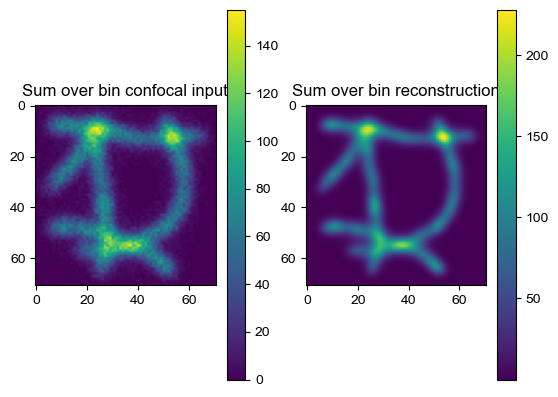

In [12]:
inv = -1

fig, (ax1, ax2) = plt.subplots(1, 2)
im1 = ax1.imshow(dataset_noise.sum(axis=(-2,-1)))
ax1.set_title('Sum over bin confocal input')
fig.colorbar(im1, orientation='vertical')
im2=ax2.imshow(result_ism[inv,0].sum(axis=-1))
ax2.set_title('Sum over bin reconstruction')
fig.colorbar(im2, orientation='vertical')

In [13]:
view = nap.view_image(dataset_noise.sum(-1))
view.add_image(result_ism[inv,0])

<Image layer 'Image [1]' at 0x7a7ff712a590>

In [30]:
n_iter = 300
result_unmix = unmix.unmixing(result_ism[inv,0], irf_dec, max_iter=n_iter, rep_to_save ='all', initialization = 'flat')[0]

Progress: 301it [00:03, 87.60it/s]                         


In [24]:
print(result_unmix[-1].sum())
print(result_ism[-1,0].sum())

120338.0
120337.984


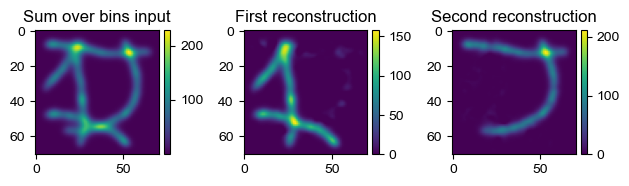

In [34]:
inv = -1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
im1 = ax1.imshow(result_ism[inv,0].sum(axis=-1))
ax1.set_title('Sum over bins input')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
im2=ax2.imshow(result_unmix[-1,0])
ax2.set_title('First reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
im3=ax3.imshow(result_unmix[-1,1])
ax3.set_title('Second reconstruction')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
fig.tight_layout()